In [6]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
from collections import Counter

In [10]:
PARQUET_PATH = "../../04_merged/all_merged.parquet"

# Required fields 
TIME_KEYS   = ["donor", "year", ]
CLONE_KEYS  = ["v_gene", "j_gene", "cdr3_aa"]
NEEDED_COLS = CLONE_KEYS + TIME_KEYS + ["isotype"] + ['cdr3_length'] + ['productive'] + ['sequence_input']

# Memory filter
MEMORY_ISOTYPES = ["IgG1","IgG2","IgG3","IgG4","IgA1","IgA2",]

# Other params
CLONOTYPE_KEYS = ['v_gene', 'j_gene', 'cdr3_aa'] 

In [11]:
# Use lazy scan for scale
lf = pl.scan_parquet(PARQUET_PATH).select(NEEDED_COLS)

# filter on productive
lf = lf.filter(
    pl.col('productive')
)

# Compute Clonotypes
lf = lf.with_columns(
    (pl.col('v_gene') + pl.lit('|') + pl.col('j_gene') + pl.lit('|') + pl.col('cdr3_aa')).alias('clonotype')
)

# Group timepoints
lf = lf.with_columns(
    pl.when(pl.col('year').is_in(["2020", "2021"]))
    .then(pl.lit('Late'))
    .otherwise(pl.lit('Early'))
    .alias('timepoint')
)

# Count timepoints and donors per clonotype
lf = lf.with_columns(
    (pl.col('timepoint').n_unique().over('clonotype').alias('n_timepoints')),
    (pl.col('donor').n_unique().over('clonotype').alias('n_donors')),
)

In [12]:
# Collect data once
df = lf.collect()

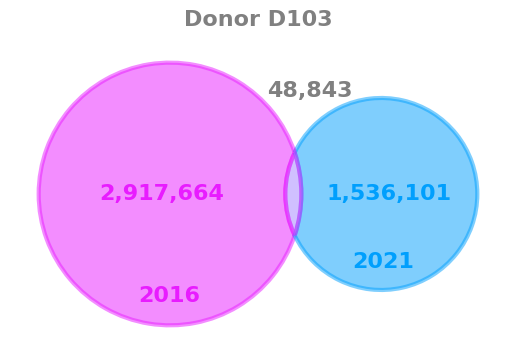

In [13]:
# Donor D103
colors = ['#e81cff', '#009ffd'] 

early = df.filter(
        (pl.col('donor') == 'D103')
        & (pl.col('year') == "2016")
    ).select('clonotype').n_unique()

late = df.filter(
        (pl.col('donor') == 'D103')
        & (pl.col('year') == "2021")
    ).select('clonotype').n_unique()

persist = df.filter(
        (pl.col('donor') == 'D103')
        & (pl.col('n_timepoints') > 1)
    ).select('clonotype').n_unique()

ax = venn2(subsets = (early, late, persist),
           set_labels = ('2016', '2021'),
           set_colors=colors,
           alpha=0.5, 
         )

# --- Apply outline (stroke) to bubbles ---
for i, subset_patch in enumerate(ax.patches):
    subset_patch.set_edgecolor(colors[i % len(colors)])
    subset_patch.set_linewidth(3)

# --- Customize Text ---
for i, text in enumerate(ax.set_labels):
    if text:
        text.set_color(colors[i])
        text.set_fontsize(16)
        text.set_fontweight('bold')

        if i == 0: # Left bubble ('2016')
            text.set_position((-0.15, -0.32)) # x, y offset from center
        elif i == 1: # Right bubble ('2021')
            text.set_position((0.38, -0.20))

subset_label_colors = [colors[0], colors[1], 'grey']

for i, text in enumerate(ax.subset_labels):
    if text:
        original_number = int(text.get_text())
        text.set_text(f"{original_number:,}") 
        text.set_color(subset_label_colors[i]) 
        text.set_fontsize(16) 
        text.set_fontweight('bold') 
        if i == 2:
            text.set_position((0.23, 0.36))


plt.title("Donor D103", fontsize=16, fontdict={'fontweight':'bold'}, color='grey')
plt.show()

In [15]:
#D103 turnover rate
num_appearing = late - persist
num_disappearing =+ early - persist
total_number_obs = late + early

D103_turnover_rate = ((num_appearing + num_disappearing)/total_number_obs)*100
print(f"Turnover rate for donor D103: {round(D103_turnover_rate,1)}%")

Turnover rate for donor D103: 97.8%


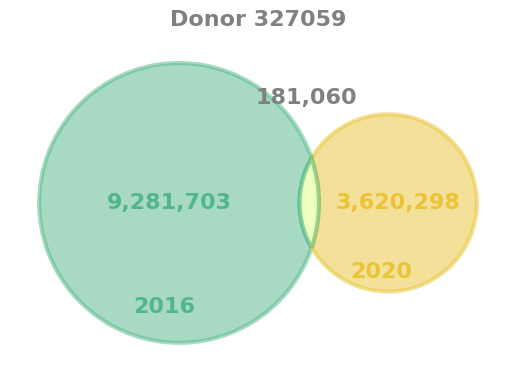

In [16]:
# Donor 327059
colors = ['#52b788', '#eac435'] 

early = df.filter(
        (pl.col('donor') == '327059')
        & (pl.col('year') == "2016")
    ).select('clonotype').n_unique()

late = df.filter(
        (pl.col('donor') == '327059')
        & (pl.col('year') == "2020")
    ).select('clonotype').n_unique()

persist = df.filter(
        (pl.col('donor') == '327059')
        & (pl.col('n_timepoints') > 1)
    ).select('clonotype').n_unique()

ax = venn2(subsets = (early, late, persist),
           set_labels = ('2016', '2020'),
           set_colors=colors,
           alpha=0.5, 
         )

# --- Apply outline (stroke) to bubbles ---
for i, subset_patch in enumerate(ax.patches):
    subset_patch.set_edgecolor(colors[i % len(colors)])
    subset_patch.set_linewidth(3)

# --- Customize Text ---
for i, text in enumerate(ax.set_labels):
    if text:
        text.set_color(colors[i])
        text.set_fontsize(16)
        text.set_fontweight('bold') # Make numbers bold

        if i == 0: # Left bubble ('2016')
            text.set_position((-0.15, -0.32)) # x, y offset from center
        elif i == 1: # Right bubble ('2020')
            text.set_position((0.38, -0.20))

subset_label_colors = [colors[0], colors[1], 'grey']

for i, text in enumerate(ax.subset_labels):
    if text:
        original_number = int(text.get_text())
        text.set_text(f"{original_number:,}") 
        text.set_color(subset_label_colors[i]) 
        text.set_fontsize(16) 
        text.set_fontweight('bold') 
        if i == 2:
            text.set_position((0.23, 0.36))


plt.title("Donor 327059", fontsize=16, fontdict={'fontweight':'bold'}, color='grey')
plt.show()

In [17]:
#D327059 turnover rate
num_appearing = late - persist
num_disappearing =+ early - persist
total_number_obs = late + early

D327059_turnover_rate=((num_appearing + num_disappearing)/total_number_obs)*100
print(f"Turnover rate for donor 327059: {round(D327059_turnover_rate,1)}%")

Turnover rate for donor 327059: 97.2%


In [19]:
average = (D103_turnover_rate+D327059_turnover_rate)/2
print(f"Average turnover: {round(average,2)}%")

Average turnover: 97.5%


In [20]:
data=[{'Donor': 'D103', 'turnover rate': D103_turnover_rate, 'sample':'All'}, 
      {'Donor': 'D327059', 'turnover rate': D327059_turnover_rate, 'sample':'All'}]

In [22]:
# In the memory compartment (IgG/IgA):
early = df.filter(
        (pl.col('donor') == 'D103')
        & (pl.col('year') == "2016")
        & (pl.col('isotype').is_in(MEMORY_ISOTYPES))
    ).select('clonotype').n_unique()

late = df.filter(
        (pl.col('donor') == 'D103')
        & (pl.col('year') == "2021")
        & (pl.col('isotype').is_in(MEMORY_ISOTYPES))
    ).select('clonotype').n_unique()

persist = df.filter(
        (pl.col('donor') == 'D103')
        & (pl.col('n_timepoints') > 1)
        & (pl.col('isotype').is_in(MEMORY_ISOTYPES))
    ).select('clonotype').n_unique()

num_appearing = late - persist
num_disappearing =+ early - persist
total_number_obs = late + early

D103_mem_turnover_rate=((num_appearing + num_disappearing)/total_number_obs)*100
print(f"Turnover rate for donor D103 (memory): {round(D103_mem_turnover_rate,1)}%")


early = df.filter(
        (pl.col('donor') == '327059')
        & (pl.col('year') == "2016")
        & (pl.col('isotype').is_in(MEMORY_ISOTYPES))
    ).select('clonotype').n_unique()

late = df.filter(
        (pl.col('donor') == '327059')
        & (pl.col('year') == "2020")
        & (pl.col('isotype').is_in(MEMORY_ISOTYPES))
    ).select('clonotype').n_unique()

persist = df.filter(
        (pl.col('donor') == '327059')
        & (pl.col('n_timepoints') > 1)
        & (pl.col('isotype').is_in(MEMORY_ISOTYPES))
    ).select('clonotype').n_unique()

num_appearing = late - persist
num_disappearing =+ early - persist
total_number_obs = late + early

D327059_mem_turnover_rate=((num_appearing + num_disappearing)/total_number_obs)*100
print(f"Turnover rate for donor 327059 (memory): {round(D327059_mem_turnover_rate,1)}%")

Turnover rate for donor D103 (memory): 93.3%
Turnover rate for donor 327059 (memory): 91.3%


In [23]:
data.extend([{'Donor': 'D103', 'turnover rate': D103_mem_turnover_rate, 'sample':'IgG/IgA'}, 
             {'Donor': 'D327059', 'turnover rate': D327059_mem_turnover_rate, 'sample':'IgG/IgA'}])

In [24]:
small_df = pd.DataFrame(data)

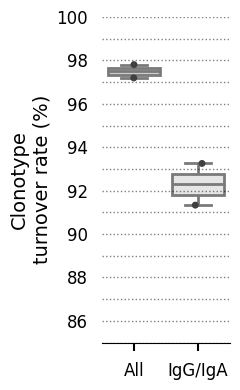

In [25]:
import numpy as np
plt.figure(figsize=(2.5,4),)
ax=sns.boxplot(data=small_df, x='sample', y='turnover rate',fliersize=0, saturation=1.,
            palette=['0.8', '0.9'], hue='sample',
            linewidth=2)
sns.stripplot(data=small_df, x='sample', y='turnover rate', ax=ax, palette=['0.25', '0.25'], hue='sample')
ax.set_ylim(85,100)
for y in np.arange(85, 101, 1):
    ls = ':'
    lw = 1
    alpha=0.5
    plt.axhline(y=y, xmin=0, xmax=10, linewidth=lw, color='k', linestyle=ls, alpha=alpha)
    
ax.set_ylabel('Clonotype\nturnover rate (%)', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.tick_params(axis='x', labelsize=12, direction='out', width=1.5, length=6, pad=8, top=False, rotation=0)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=4, right=False, left=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('./2c_turnover_rate.svg', dpi=1200)
plt.show()

### WebLogos

In [45]:
%pip install weblogo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.7/571.7 kB 24.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [26]:
from weblogo import read_seq_data, LogoData, LogoOptions, LogoFormat, eps_formatter
from weblogo.colorscheme import ColorScheme, IndexColor, SymbolColor

In [27]:
persistent = df.filter(pl.col('n_timepoints')>1).select('cdr3_aa')
non_persistent = df.filter(pl.col('n_timepoints')==1).select('cdr3_aa')

In [28]:
with open('./persistent_cdr3s','w') as f:
    for i, s in enumerate(persistent["cdr3_aa"].to_list()):
        if s:
            if len(s) == 13:
                f.write(f">{i}\n")
                f.write(f"{s}\n")

In [29]:
with open('./non_persistent_cdr3s','w') as f:
    for i, s in enumerate(non_persistent["cdr3_aa"].to_list()):
        if s:
            if len(s) == 13:
                f.write(f">{i}\n")
                f.write(f"{s}\n")

In [30]:
opts_kwargs = {'unit_name': 'probability',
               'show_xaxis': False,
               'show_yaxis': False,
               'show_fineprint': False,
               'stack_aspect_ratio': 3}
rules_13AA = [IndexColor(range(3), '#C0C0C0'),
              IndexColor(range(10, 13), '#C0C0C0'),
              SymbolColor("GSTYC", "green", "polar"),
              SymbolColor("NQ", "purple", "neutral"),
              SymbolColor("KRH", "blue", "basic"),
              SymbolColor("DE", "red", "acidic"),
              SymbolColor("PAWFLIMV", "black", "hydrophobic")]

colorscheme_13AA = ColorScheme(rules_13AA)

options = LogoOptions(**opts_kwargs)
options.color_scheme = colorscheme_13AA

In [23]:
# Persistent fraction
with open('./persistent_cdr3s') as f:
    seqs = read_seq_data(f)
    data = LogoData.from_seqs(seqs)
    fmt = LogoFormat(data, options)
    eps = eps_formatter(data, fmt)
    with open('./2d_persistent_13AA_weblogo.eps', 'wb') as eps_file:
            eps_file.write(eps)

In [24]:
# Non persistent fraction
with open('./non_persistent_cdr3s') as f:
    seqs = read_seq_data(f)
    data = LogoData.from_seqs(seqs)
    fmt = LogoFormat(data, options)
    eps = eps_formatter(data, fmt)
    with open('./2d_non_persistent_13AA_weblogo.eps', 'wb') as eps_file:
            eps_file.write(eps)

### CDR3 lengths

In [31]:
p = Counter(df.filter(pl.col('n_timepoints')>1).select('cdr3_length')['cdr3_length'])

In [32]:
s = df.select(['n_timepoints','cdr3_length'])

In [33]:
s.filter(pl.col('n_timepoints')>1).select('cdr3_length')['cdr3_length'].describe()

statistic,value
str,f64
"""count""",1.0554041e7
"""null_count""",0.0
"""mean""",13.632753
"""std""",3.485067
"""min""",1.0
"""25%""",11.0
"""50%""",14.0
"""75%""",16.0
"""max""",50.0


In [34]:
s.filter(pl.col('n_timepoints')==1).select('cdr3_length')['cdr3_length'].describe()

statistic,value
str,f64
"""count""",5.0358369e7
"""null_count""",0.0
"""mean""",15.447699
"""std""",3.922845
"""min""",0.0
"""25%""",13.0
"""50%""",15.0
"""75%""",18.0
"""max""",114.0


In [35]:
np = Counter(df.filter(pl.col('n_timepoints')==1).select('cdr3_length')['cdr3_length'])

In [36]:
len_data={'persistent': p, 'non-persistent': np}

In [37]:
len_df=pd.DataFrame(len_data).fillna(0)
len_df=len_df/len_df.sum()

In [38]:
len_df.sort_index(inplace=True)

In [39]:
def step(x, ys, colors=None, labels=None, figfile=None, figsize=(8, 3), color=[0.3] * 3,
                ylim=None, xlim=None, xtick_interval=1, linewidth=1.25, xlabel=None, show_legend=False):
    
    sns.set_style('white')

    # set some reasonable defaults (if not provided)
    if xlim is None:
        xlim = (-0.5, len(xs))
    if ylim is None:
        ylim = (0, 1.1 * max([max(y) for y in ys]))
    if colors is None:
        colors = sns.color_palette('muted', len(ys))
    if labels is None:
        labels = [None] * len(ys)

    # plot the data
    plt.figure(figsize=figsize)
    for y, color, label in zip(ys, colors, labels):
        plot = plt.step(x, y, where='mid', color=color, linewidth=linewidth, label=label)
        plt.fill_between(x, y, step='mid', color=color, alpha=0.1)

    # axis labels and ticks
    ax = plt.gca()
    ax.set_ylabel('Frequency', size=14, labelpad=8)
    if xlabel is not None:
        ax.set_xlabel(xlabel, size=14, labelpad=8)
    plt.xticks(x[::xtick_interval], x[::xtick_interval], size='medium')
    ax.tick_params(axis='x', which='major', labelsize=12)
    ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=12, right=False)
    
    # hide top, left and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # axis limits
    ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    # legend
    if show_legend:
        plt.legend(fontsize=12, handlelength=1)
    
    # save or show
    plt.tight_layout()
    if figfile is not None:
        plt.savefig(figfile)
    else:
        plt.show()

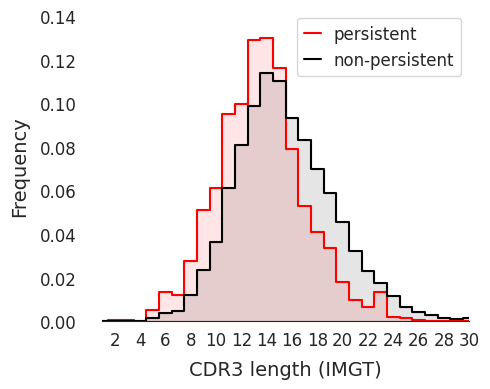

In [40]:
x = len_df.index.values
labels = len_df.columns.values
ys = [list(len_df[l]) for l in labels]
colors = ['r', 'k']

step(x, ys, colors=colors, labels=labels, xlim=[1, 30], xtick_interval=2,
     figsize=(5, 4), linewidth=1.5, xlabel='CDR3 length (IMGT)', show_legend=True,
      figfile='./2e_persistent_CDR3len_step-plot.svg'
    )